In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd
#import rdlib8 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

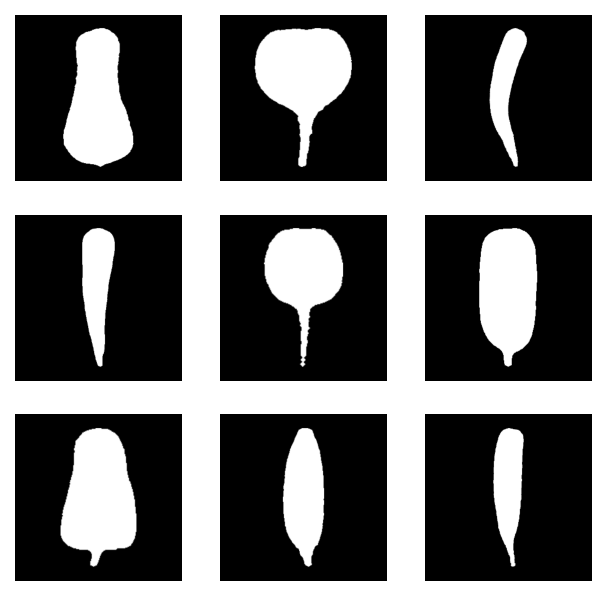

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [3]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll,tover=0.1,tunder=-0.1)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

In [4]:
#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting2(func,ts,cont,err_th=0.5,of_th=0.5):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    print('\n',len(cont),Nsamples,axlength,span,of_th*span)# 
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    '''difsm = np.array([np.mean(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75m, q25m = np.percentile(difsm, [75,25]) # 四分位点
    oddsm = np.where((difsm>q75m+1.5*(q75m-q25m))) # 異常値のインデックス
    oddsm = np.where(difsm > of_th) # '''
    print(odds,[difs[i] for i in odds0])
    #print([difsm[i] for i in oddsm])
    return odds # ,oddsm 

In [5]:
def testOF(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,mode=1,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1T(tpara=[],mode=mode,err_th=0.5,lr=lr,lrP=lrP,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

def testOF1(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1(tpara=[],err_th=err_th,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

def f_meanerr(fx, fy, ts,samples):
    sps = samples
    # fx, fy : t の symfy関数、ts: ベジエのパラメータのリスト, sps サンプル点のリスト
    t = symbols('t')
    nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
    onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]   
    return mean([(sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2 for i in range(len(sps))])

def testF0(imgn=0,N=7,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1,dbtmdr=3) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit0(tpara=[],withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    print("ERR",f_meanerr(func[0],func[1],bez.ts,Samples))
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

In [6]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = isOverFitting2(func,bez.ts,conAll,of_th=0.5)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th and len(odds)==0:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

16
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([2.61162935, 2.88913905])]
17
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([2.26684619, 2.58024357, 2.78664187])]
18
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([1.94226631, 1.95869447])]
19
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([2.1292198 , 1.71080563])]
20
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([1.83506935, 2.11019451])]
21
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([1.78776919, 1.85778604])]
22
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([1.97556996])]
23
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([1.8390033])]
24
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([], dtype=float64)]

N= 24  err = 0.6181412097301506   etime = 5.859375
Wall time: 1min


{'16': (array([], dtype=int64), 1.1160622144990864, 2.65625),
 '17': (array([], dtype=int64), 0.7946460046458168, 2.90625),
 '18': (array([], dtype=int64), 0.7724205990353706, 3.375),
 '19': (array([], dtype=int64), 0.7496932776336029, 3.59375),
 '20': (array([], dtype=int64), 0.7153673878314293, 4.03125),
 '21': (array([], dtype=int64), 0.7113879071539896, 4.390625),
 '22': (array([], dtype=int64), 0.6915098215029294, 4.9375),
 '23': (array([], dtype=int64), 0.6317099994675911, 5.34375),
 '24': (array([], dtype=int64), 0.6181412097301506, 5.859375)}

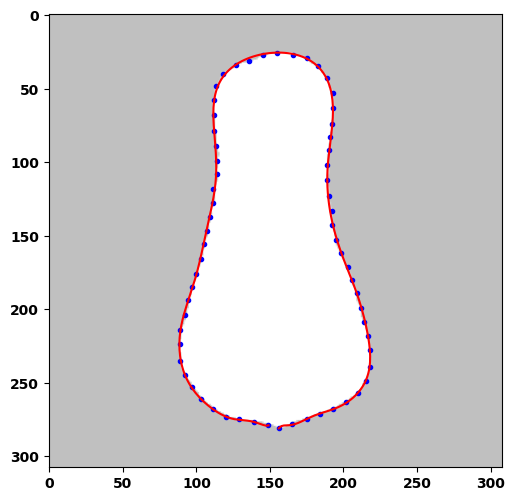

In [7]:
%%time
results= check0N(0,Nsamples=65,Nfrom=16,Nto=24,err_th=0.5,withFig=True)
results

25
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([2.14638728])]
26
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([], dtype=float64)]
27
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([], dtype=float64)]
28
 609 65 682.1442233324051 10.65850348956883 5.329251744784415
[] [array([1.83197504, 1.41233875])]

N= 28  err = 0.4882397213894213   etime = 8.03125
Wall time: 43.2 s


{'25': (array([], dtype=int64), 0.5747030238053777, 6.296875),
 '26': (array([], dtype=int64), 0.5556862489071129, 6.828125),
 '27': (array([], dtype=int64), 0.5367218950370739, 7.5625),
 '28': (array([], dtype=int64), 0.4882397213894213, 8.03125)}

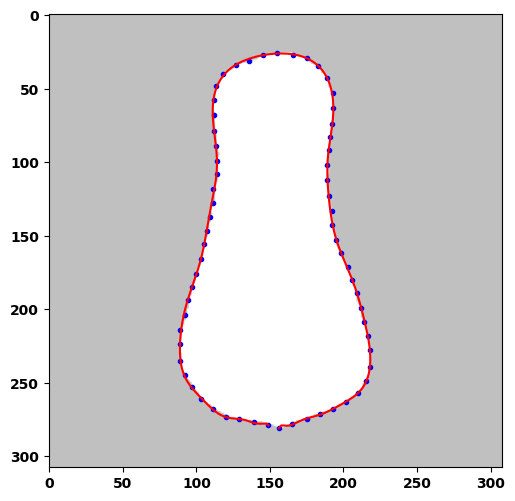

In [8]:
%%time
results= check0N(0,Nsamples=65,Nfrom=25,Nto=33,err_th=0.5,withFig=True)
results

17
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([4.02558154, 2.85574803, 2.84063351])]
18
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.45863016, 2.35100191, 2.82150791, 2.29681682, 4.17810054,
       2.22160898, 2.72586226, 2.33335721])]

N= 18  err = 0.9870404129984165   etime = 3.421875
Wall time: 10.9 s


{'17': (array([], dtype=int64), 1.0952129026912856, 2.921875),
 '18': (array([], dtype=int64), 0.9870404129984165, 3.421875)}

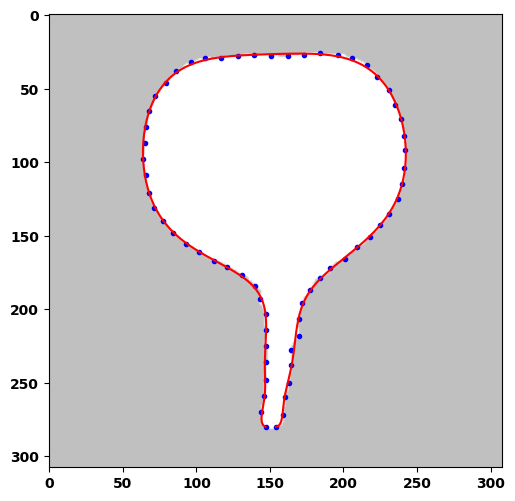

In [9]:
%%time
results= check0N(1,Nsamples=65,Nfrom=17,Nto=18,err_th=1.0,withFig=True)
results

19
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.55075839, 2.6784779 , 2.56502182, 2.20089484])]
20
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.34455843, 2.68171415, 2.17297302, 2.19395686, 2.31723591,
       3.00674241])]
21
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([4.84072522, 2.76053442, 2.11221583, 2.37951458, 2.62247731])]
22
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.28451679, 2.03739456, 1.95913201, 1.85862348])]
23
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.98221088])]
24
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.73033398, 3.0308737 , 2.34401037, 2.47311794])]
25
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.29579387])]
26
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([1.98875911, 2.08358387])]
27
 658 65 750.6122596263885 

{'19': (array([], dtype=int64), 0.945893869683127, 3.640625),
 '20': (array([], dtype=int64), 0.7560472434678588, 4.046875),
 '21': (array([], dtype=int64), 0.7462088670368533, 4.4375),
 '22': (array([], dtype=int64), 0.6894947664400286, 5.125),
 '23': (array([], dtype=int64), 0.6503994721257615, 5.453125),
 '24': (array([], dtype=int64), 0.6144925818328378, 5.921875),
 '25': (array([], dtype=int64), 0.6104878346861371, 6.421875),
 '26': (array([], dtype=int64), 0.5748761423160886, 6.9375),
 '27': (array([], dtype=int64), 0.5691761908495168, 7.453125),
 '28': (array([], dtype=int64), 0.5631044030150515, 8.03125),
 '29': (array([], dtype=int64), 0.5200602125705843, 8.546875),
 '30': (array([], dtype=int64), 0.5106003355802203, 9.328125)}

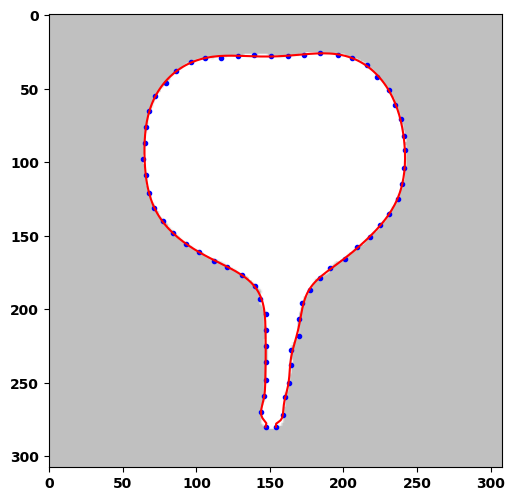

In [10]:
%%time
results= check0N(1,Nsamples=65,Nfrom=19,Nto=30,err_th=0.5,withFig=True)
results

19
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.55075839, 2.6784779 , 2.56502182, 2.20089484])]
20
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.34455843, 2.68171415, 2.17297302, 2.19395686, 2.31723591,
       3.00674241])]
21
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([4.84072522, 2.76053442, 2.11221583, 2.37951458, 2.62247731])]
22
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.28451679, 2.03739456, 1.95913201, 1.85862348])]
23
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.98221088])]
24
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.73033398, 3.0308737 , 2.34401037, 2.47311794])]
25
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([2.29579387])]
26
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[] [array([1.98875911, 2.08358387])]
27
 658 65 750.6122596263885 

{'19': (array([], dtype=int64), 0.945893869683127, 3.796875),
 '20': (array([], dtype=int64), 0.7560472434678588, 4.09375),
 '21': (array([], dtype=int64), 0.7462088670368533, 4.5),
 '22': (array([], dtype=int64), 0.6894947664400286, 4.9375),
 '23': (array([], dtype=int64), 0.6503994721257615, 5.421875),
 '24': (array([], dtype=int64), 0.6144925818328378, 5.953125),
 '25': (array([], dtype=int64), 0.6104878346861371, 6.40625),
 '26': (array([], dtype=int64), 0.5748761423160886, 6.921875),
 '27': (array([], dtype=int64), 0.5691761908495168, 7.484375),
 '28': (array([], dtype=int64), 0.5631044030150515, 8.046875),
 '29': (array([], dtype=int64), 0.5200602125705843, 8.59375),
 '30': (array([], dtype=int64), 0.5106003355802203, 9.390625),
 '31': (array([], dtype=int64), 0.5060718334144575, 9.828125),
 '32': (array([], dtype=int64), 0.5473884325105216, 10.65625),
 '33': (array([63], dtype=int64), 0.4967743337917713, 11.25)}

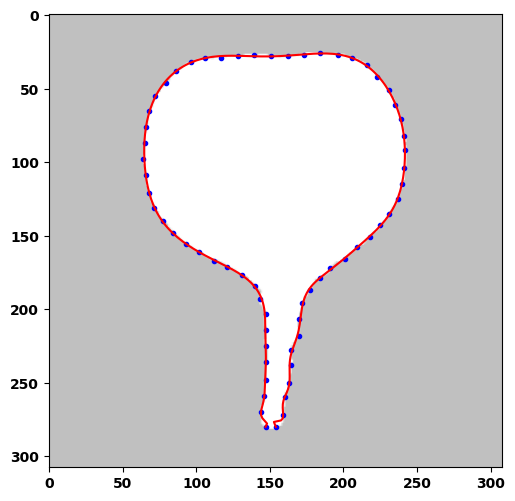

In [11]:
%%time
results= check0N(1,Nsamples=65,Nfrom=19,Nto=33,err_th=0.5,withFig=True)
results

34
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[63] [array([3.41314656, 2.12516106, 9.16689161])]
35
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[63] [array([ 2.56043978,  2.19257936, 11.29061936])]
36
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[63] [array([9.0055001])]
37
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[63] [array([ 1.91226521, 11.99490982])]
38
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[63] [array([ 3.43033517,  2.40431773, 29.50376034])]
39
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[63] [array([ 3.72501699,  2.03054779, 11.41628238])]
40
 658 65 750.6122596263885 11.728316556662321 5.8641582783311605
[ 0  1 63] [array([108.93073753,  10.84193761,   3.5108394 ,   2.25265442,
         3.86892997,  57.84210555])]

N= 40  err = 0.6264887725785399   etime = 18.328125
Wall time: 2min 17s


{'34': (array([63], dtype=int64), 0.483585708627433, 13.625),
 '35': (array([63], dtype=int64), 0.4824416903532889, 14.140625),
 '36': (array([63], dtype=int64), 0.4836783717388023, 14.984375),
 '37': (array([63], dtype=int64), 0.5329010265128536, 15.640625),
 '38': (array([63], dtype=int64), 0.5065718049849417, 16.359375),
 '39': (array([63], dtype=int64), 0.4622539874717359, 17.359375),
 '40': (array([ 0,  1, 63], dtype=int64), 0.6264887725785399, 18.328125)}

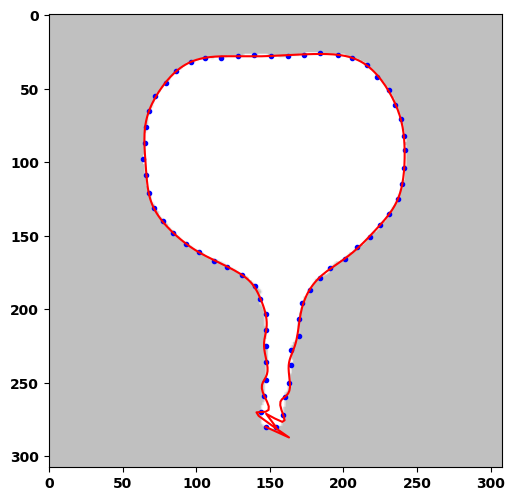

In [12]:
%%time
results= check0N(1,Nsamples=65,Nfrom=34,Nto=40,err_th=0.5,withFig=True)
results

18
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([], dtype=float64)]
19
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([2.30590214, 3.05794636, 2.23099758, 2.48797337, 2.75010727])]
20
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([2.08768958, 2.14346819])]
21
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([], dtype=float64)]
22
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([], dtype=float64)]
23
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([1.82715136, 1.91997259])]
24
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([1.98274383])]
25
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([1.66429771, 1.80108667])]
26
 526 65 592.5168067216873 9.258075105026364 4.629037552513182
[] [array([1.35783056, 2.16676676])]

N= 26  err = 0.4040764910004016   etime = 7.0625
Wall time: 1min 14s


{'18': (array([], dtype=int64), 1.1414699085019477, 3.34375),
 '19': (array([], dtype=int64), 1.0435786906328801, 3.71875),
 '20': (array([], dtype=int64), 0.9128332947704467, 4.09375),
 '21': (array([], dtype=int64), 0.8632684192280394, 4.625),
 '22': (array([], dtype=int64), 0.776634619564677, 5.015625),
 '23': (array([], dtype=int64), 0.716984918248834, 5.5),
 '24': (array([], dtype=int64), 0.550139230997995, 6.0),
 '25': (array([], dtype=int64), 0.5275046083243753, 6.46875),
 '26': (array([], dtype=int64), 0.4040764910004016, 7.0625)}

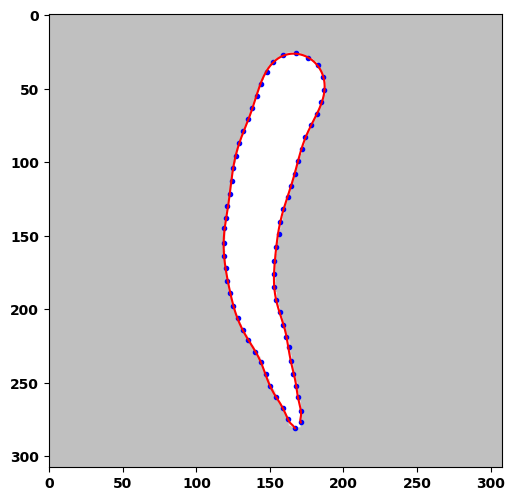

In [13]:
%%time
results= check0N(2,Nsamples=65,Nfrom=18,Nto=40,err_th=0.5,withFig=True)
results

14
 536 65 570.2081507444382 8.909502355381846 4.454751177690923
[] [array([3.5045642 , 3.79650003, 3.79869698, 2.51876132, 2.88090062,
       2.49646998])]
15
 536 65 570.2081507444382 8.909502355381846 4.454751177690923
[] [array([1.81912012, 2.19444401, 1.74309926, 2.16604185])]
16
 536 65 570.2081507444382 8.909502355381846 4.454751177690923
[] [array([1.94215869, 3.92566767, 1.70928231, 1.96707929, 1.7217953 ])]
17
 536 65 570.2081507444382 8.909502355381846 4.454751177690923
[] [array([2.32011678, 1.69488329])]
18
 536 65 570.2081507444382 8.909502355381846 4.454751177690923
[] [array([2.41597913, 1.9622471 ])]
19
 536 65 570.2081507444382 8.909502355381846 4.454751177690923
[] [array([1.61100756])]

N= 19  err = 0.4721021600306817   etime = 3.734375
Wall time: 31.4 s


{'14': (array([], dtype=int64), 1.3416010598554227, 2.0),
 '15': (array([], dtype=int64), 1.0187812287342004, 2.453125),
 '16': (array([], dtype=int64), 0.8954394086176877, 2.640625),
 '17': (array([], dtype=int64), 0.6634174261401288, 3.015625),
 '18': (array([], dtype=int64), 0.6380129722961116, 3.34375),
 '19': (array([], dtype=int64), 0.4721021600306817, 3.734375)}

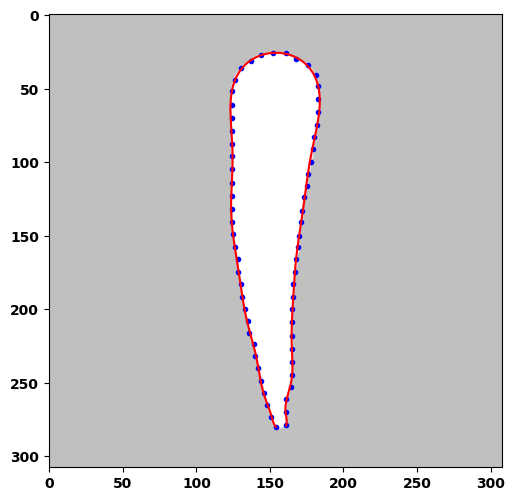

In [14]:
%%time
results= check0N(3,Nsamples=65,Nfrom=14,Nto=40,err_th=0.5,withFig=True)
results

19
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[63] [array([3.31644829, 3.57665125, 3.48862139, 3.44924675, 5.96044636])]
20
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[63] [array([3.37723979, 2.33002794, 3.4096194 , 2.59560516, 4.45239942,
       2.38867388, 2.36857862, 6.15502897])]
21
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[] [array([2.95673595, 2.90197437, 3.81414083, 4.59831575])]
22
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[] [array([2.19620958, 2.71316876, 3.49436918, 2.26160449, 3.54977021])]
23
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[] [array([2.53538902, 3.97144228, 2.3708336 ])]
24
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[] [array([2.50350861, 3.3409046 , 2.63976126])]
25
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[] [array([2.49236644, 2.16535009, 3.3287149 , 2.16122378, 2.65546151])]
26
 644 65 725.0142805576324 11.3

{'19': (array([63], dtype=int64), 1.0468702675091006, 3.734375),
 '20': (array([63], dtype=int64), 1.0016413182534292, 4.140625),
 '21': (array([], dtype=int64), 0.968007782803697, 4.625),
 '22': (array([], dtype=int64), 0.7758415697510135, 5.0),
 '23': (array([], dtype=int64), 0.7062156515858707, 5.671875),
 '24': (array([], dtype=int64), 0.6776313646289237, 6.015625),
 '25': (array([], dtype=int64), 0.6775250285200537, 6.53125),
 '26': (array([], dtype=int64), 0.6724314709481956, 7.046875),
 '27': (array([], dtype=int64), 0.6369231135194539, 7.546875),
 '28': (array([], dtype=int64), 0.6468613006751456, 8.21875),
 '29': (array([], dtype=int64), 0.6349437039659235, 8.890625),
 '30': (array([], dtype=int64), 0.5987513016322021, 9.328125),
 '31': (array([], dtype=int64), 0.6061609780397521, 10.09375),
 '32': (array([], dtype=int64), 0.6423628055236885, 10.78125),
 '33': (array([0], dtype=int64), 0.563599273829165, 11.390625),
 '34': (array([], dtype=int64), 0.5462225805901222, 13.5625),

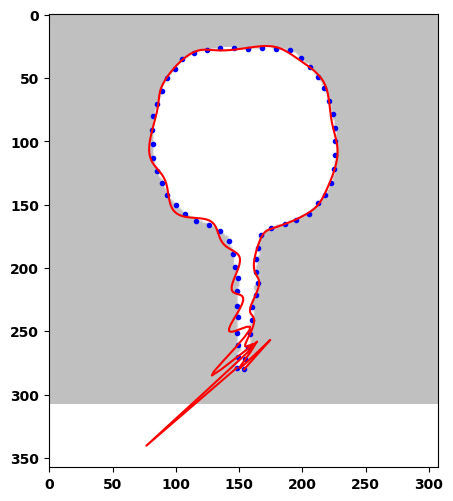

In [15]:
%%time
results= check0N(4,Nsamples=65,Nfrom=19,Nto=40,err_th=0.5,withFig=True)
results

30
 644 65 725.0142805576324 11.328348133713007 5.6641740668565035
[] [array([2.02976833, 4.15833978, 3.02836863])]

N= 30  err = 0.5987513016322021   etime = 9.265625
Wall time: 13.1 s


{'30': (array([], dtype=int64), 0.5987513016322021, 9.265625)}

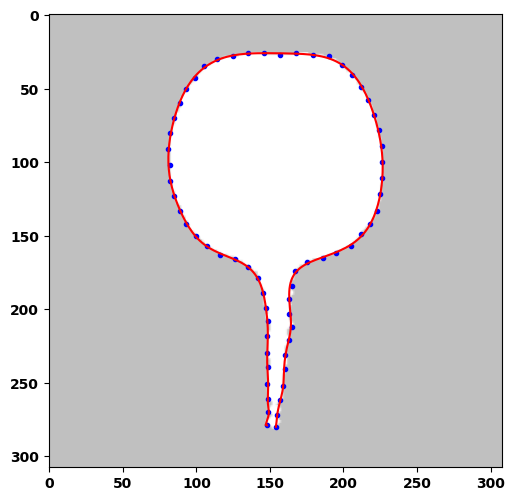

In [16]:
%%time
results= check0N(4,Nsamples=65,Nfrom=30,Nto=30,err_th=0.5,withFig=True)
results

以下30次で打ち切り

14
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([2.97724716, 3.12896007, 3.72875473])]
15
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([1.92099569, 1.96980873, 1.86838566])]
16
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([1.74413249, 1.69344611, 2.28420799])]
17
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([1.58946011, 1.55721082, 2.24079736, 1.70781578])]
18
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([1.84684356])]
19
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([1.44003104, 1.82274616, 1.45735533])]
20
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([1.51661906, 1.44862475])]
21
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([], dtype=float64)]
22
 571 65 630.4751765727997 9.851174633949995 4.9255873169749975
[] [array([2.2239146])]
23
 571 65 630.4751765727997 9.85

{'14': (array([], dtype=int64), 1.1483417793864361, 1.9375),
 '15': (array([], dtype=int64), 0.747524885592218, 2.25),
 '16': (array([], dtype=int64), 0.7075674418941661, 2.546875),
 '17': (array([], dtype=int64), 0.710126497120555, 2.890625),
 '18': (array([], dtype=int64), 0.6654825494702145, 3.265625),
 '19': (array([], dtype=int64), 0.6448483737933479, 3.640625),
 '20': (array([], dtype=int64), 0.5885474770246173, 4.03125),
 '21': (array([], dtype=int64), 0.5611483685025324, 4.46875),
 '22': (array([], dtype=int64), 0.5456454020937772, 4.90625),
 '23': (array([], dtype=int64), 0.5039404626562498, 5.34375),
 '24': (array([], dtype=int64), 0.4526622495161467, 5.8125)}

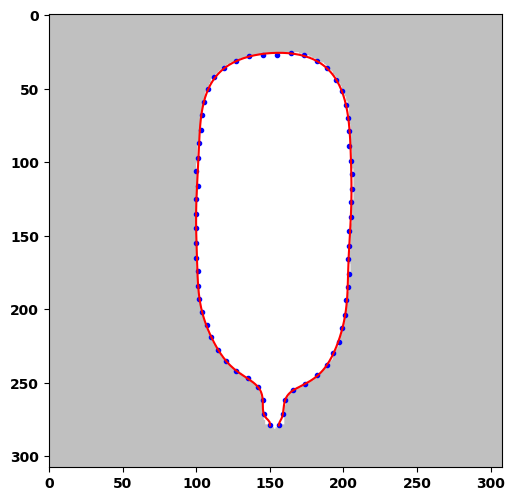

In [17]:
%%time
results= check0N(5,Nsamples=65,Nfrom=14,Nto=30,err_th=0.5,withFig=True)
results

15
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([3.10930981, 3.47980566, 3.05546925])]
16
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([2.448438])]
17
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([1.95443627])]
18
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([2.21942366])]
19
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([1.64465531, 2.06780959, 1.58796861, 2.41806592, 1.74932522])]
20
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([3.14354735, 2.56383406])]
21
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([1.76177792])]
22
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([2.26584564])]
23
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([2.81909325])]
24
 631 65 697.1025931835175 10.89222801849246 5.44611400924623
[] [array([2.0188663])]
25
 631 65 697.1025931835175 

{'15': (array([], dtype=int64), 1.2054084236107259, 2.265625),
 '16': (array([], dtype=int64), 1.075171014449516, 2.6875),
 '17': (array([], dtype=int64), 0.7901416320480551, 3.109375),
 '18': (array([], dtype=int64), 0.7479907413057622, 3.28125),
 '19': (array([], dtype=int64), 0.7027168524352511, 3.6875),
 '20': (array([], dtype=int64), 0.669671683917895, 4.234375),
 '21': (array([], dtype=int64), 0.6159710391594003, 4.515625),
 '22': (array([], dtype=int64), 0.5895232845248539, 4.96875),
 '23': (array([], dtype=int64), 0.5766198368875406, 5.4375),
 '24': (array([], dtype=int64), 0.5409914590835472, 5.859375),
 '25': (array([], dtype=int64), 0.5270020889622636, 6.421875),
 '26': (array([], dtype=int64), 0.5083062486714932, 7.0625),
 '27': (array([], dtype=int64), 0.47771998904240065, 7.5)}

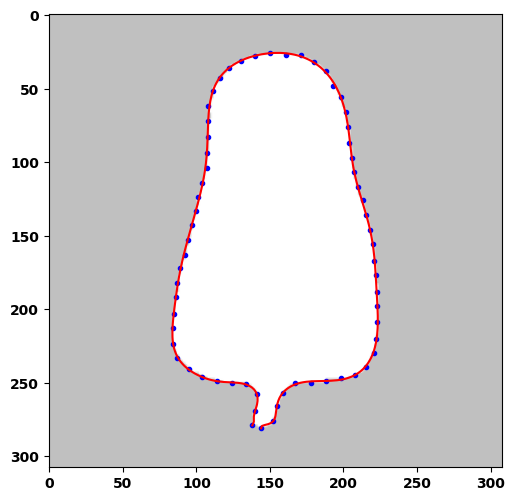

In [18]:
%%time
results= check0N(6,Nsamples=65,Nfrom=15,Nto=30,err_th=0.5,withFig=True)
results

18
 532 65 584.0193328857422 9.125302076339722 4.562651038169861
[] [array([1.85678483, 3.80009161, 4.08656985, 2.98841844, 2.29801753,
       3.07444672, 1.88747667])]
19
 532 65 584.0193328857422 9.125302076339722 4.562651038169861
[] [array([3.59269404, 3.16913453, 3.10305971, 1.92725298, 3.37659675,
       2.2160054 ])]
20
 532 65 584.0193328857422 9.125302076339722 4.562651038169861
[] [array([1.84067324, 3.83596168, 3.30968911, 2.44138935, 2.80616173,
       1.97426427])]
21
 532 65 584.0193328857422 9.125302076339722 4.562651038169861
[0] [array([16.4721219 ,  2.92514893,  2.58018649,  2.72093517,  1.89949623,
        2.50805912])]
22
 532 65 584.0193328857422 9.125302076339722 4.562651038169861
[] [array([4.04765178, 2.8783072 , 2.2088331 ])]
23
 532 65 584.0193328857422 9.125302076339722 4.562651038169861
[] [array([1.93154196, 2.08874257, 1.75817557, 1.70927354, 1.76118912])]
24
 532 65 584.0193328857422 9.125302076339722 4.562651038169861
[] [array([1.52811991, 2.28077985, 2

{'18': (array([], dtype=int64), 1.0168559103445343, 3.375),
 '19': (array([], dtype=int64), 0.9755840861429346, 3.921875),
 '20': (array([], dtype=int64), 0.935754920980024, 4.0625),
 '21': (array([0], dtype=int64), 0.8671945967703507, 4.5625),
 '22': (array([], dtype=int64), 0.7674096538961682, 4.96875),
 '23': (array([], dtype=int64), 0.7146562355333269, 5.421875),
 '24': (array([], dtype=int64), 0.6747264237728716, 5.9375),
 '25': (array([], dtype=int64), 0.6584973983321284, 6.46875),
 '26': (array([], dtype=int64), 0.6371919471734578, 6.9375),
 '27': (array([], dtype=int64), 0.6172435504524076, 7.484375),
 '28': (array([], dtype=int64), 0.5921698559494519, 8.109375),
 '29': (array([], dtype=int64), 0.5370309236749633, 8.640625),
 '30': (array([], dtype=int64), 0.5435361845514636, 9.453125)}

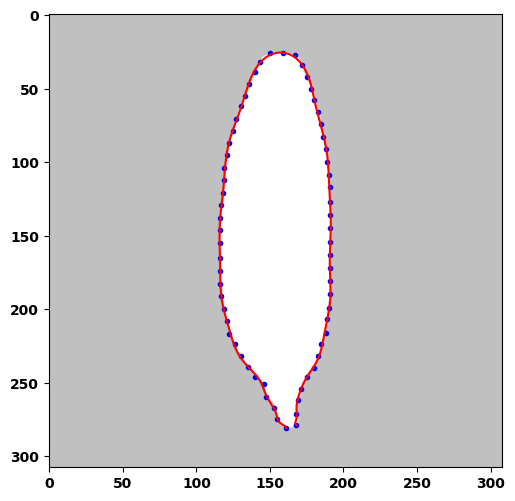

In [19]:
%%time
results= check0N(7,Nsamples=65,Nfrom=18,Nto=30,err_th=0.5,withFig=True)
results

16
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[29] [array([3.34564432, 3.23837772, 2.893274  , 4.45904699, 3.41320454])]
17
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([2.23819227, 2.49080048, 2.18576539])]
18
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([2.4061696 , 2.39826396, 2.03424308, 2.15457224])]
19
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([1.71262657, 2.21824769, 1.657565  , 1.49836802, 1.67445686])]
20
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([1.58781359, 1.82390623, 1.62800707, 1.61720726])]
21
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([], dtype=float64)]
22
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([], dtype=float64)]
23
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([1.81024198])]
24
 531 65 569.7644996643066 8.902570307254791 4.451285153627396
[] [array([

{'16': (array([29], dtype=int64), 1.249496441163297, 2.59375),
 '17': (array([], dtype=int64), 1.0104455142998778, 2.96875),
 '18': (array([], dtype=int64), 0.879464485982862, 3.296875),
 '19': (array([], dtype=int64), 0.7811616479473432, 3.921875),
 '20': (array([], dtype=int64), 0.7112979548125267, 4.078125),
 '21': (array([], dtype=int64), 0.6848929549212004, 4.5),
 '22': (array([], dtype=int64), 0.6319226539976377, 4.96875),
 '23': (array([], dtype=int64), 0.5600630611033386, 5.421875),
 '24': (array([], dtype=int64), 0.5180628286577678, 6.125),
 '25': (array([], dtype=int64), 0.4799621706484185, 6.4375)}

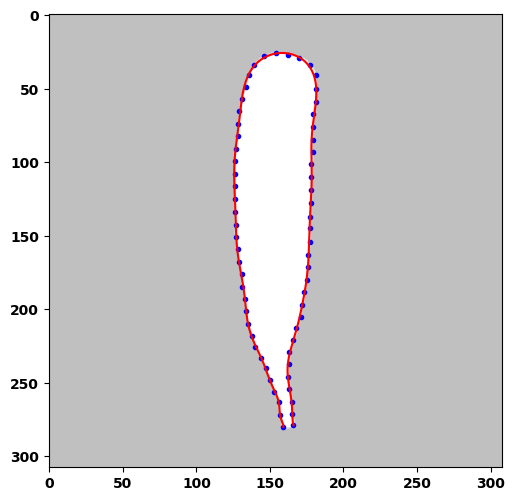

In [20]:
%%time
results= check0N(8,Nsamples=65,Nfrom=16,Nto=30,err_th=0.5,withFig=True)
results